In [2]:
import nengo
import numpy as np
import matplotlib.pyplot as plt

In [1]:
class Environment:
    def __init__(self):
        self.theta = 0
        
    def update(self, x):
        if x[0] > 0:
            self.theta += 0.01
        if x[1] > 0:
            self.theta -= 0.01
        reward = 1 if np.cos(self.theta)>0.95 else 0
        return np.sin(self.theta), np.cos(self.theta), reward

In [6]:
tau_slow = 0.01
tau_fast = None
discount = 0.95

environment = Environment()
model = nengo.Network()
with model:
    
    # create the environment
    #   it has 3 outputs: the first 2 are the state, and the last is the reward
    env = nengo.Node(lambda t, x: environment.update(x), size_in=2, size_out=3)
    
    # set up some other Nodes that just grab the state and reward information,
    #  just for clarity
    state = nengo.Node(None, size_in=2)
    nengo.Connection(env[:2], state, synapse=None)
    reward = nengo.Node(None, size_in=1)
    nengo.Connection(env[2], reward, synapse=None)
    
    # create the neural network to encode the state.  The default is LIF neurons.
    ens = nengo.Ensemble(n_neurons=200, dimensions=2)
    nengo.Connection(state, ens, synapse=None)
    
    # this is the output value that we critic will learn
    value = nengo.Node(None, size_in=1)

    # record the value and the reward
    p_value = nengo.Probe(value)
    p_reward = nengo.Probe(reward)
    
    # compute the critic error
    value_error = nengo.Node(None, size_in=1)
    nengo.Connection(value, value_error, transform=-discount, synapse=tau_fast)
    nengo.Connection(value, value_error, synapse=tau_slow)
    nengo.Connection(reward, value_error, transform=-1, synapse=tau_slow)
    
    # make the connection to learn on
    c = nengo.Connection(ens.neurons, value, transform=np.zeros((1, ens.n_neurons)), 
                         learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))
    # connect the error signal to the learning rule
    nengo.Connection(value_error, c.learning_rule, synapse=None)

    ### HERE IS THE NEW STUFF FOR THE ACTOR
    
    # the raw output from the network
    raw_actions = nengo.Node(None, size_in=2, label='raw_actions')
    
    # compute the softmax
    def softmax(t, x):
        return np.exp(x)/np.sum(np.exp(x))
    actions = nengo.Node(softmax, size_in=2, label='actions')
    nengo.Connection(raw_actions, actions, synapse=None)

    # do the random sampling and output which action we're taking
    #  (here I just decided to represent choosing the action as +1 and not choosing as -1)
    def choice_func(t, x):
        c = np.random.choice(np.arange(2), p=x)
        result = [-1, -1]
        result[c] = 1
        return result
    choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
    nengo.Connection(actions, choice, synapse=None)
    
    # and now connect the choice to the environment
    nengo.Connection(choice, env, synapse=None)
    
    # and here is the computation of the error signal
    c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
                               learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))

    # implement the advantage actor-critic error rule
    #  the Node gets 5 inputs: the delta for the critic part, 2 values indicating which action was chosen
    #  (+1 for the chosen and -1 for the non-chosen ones), and the choice probabilities for the 2 actions
    def actor_error_func(t, x):
        delta = x[0]
        chosen = x[1:3]
        prob = x[3:5]
        # compute the error
        e = np.where(chosen>0, delta*(1-prob), -delta*prob)
        return e

    actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
    nengo.Connection(value_error, actor_error[0], synapse=None)
    nengo.Connection(choice, actor_error[1:3], synapse=None)
    nengo.Connection(actions, actor_error[3:5], synapse=None)
    nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=tau_slow) 
    
    p_choice = nengo.Probe(choice)   # record the actual choices
    p_prob = nengo.Probe(actions)    # record the probabilities 

In [11]:
sim = nengo.Simulator(model)
sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

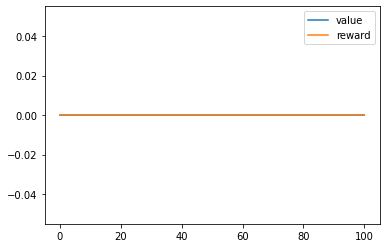

In [13]:
plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()

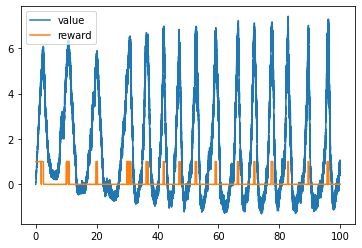

In [8]:
plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()

In [14]:
sim.run(500)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

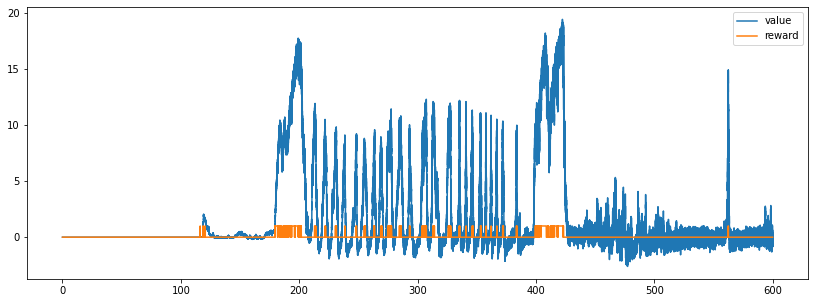

In [15]:
plt.figure(figsize=(14,5))
plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()